<img width="800px" src="../fidle/img/00-Fidle-header-01.svg"></img>

# <!-- TITLE --> [VAE7] - Checking the clustered CelebA dataset
<!-- DESC --> Check the clustered dataset
<!-- AUTHOR : Jean-Luc Parouty (CNRS/SIMaP) -->

## Objectives :
 - Making sure our clustered dataset is correct
 - Do a little bit of python while waiting to build and train our VAE model.

The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) contains about 200,000 images (202599,218,178,3).  


## What we're going to do :

 - Reload our dataset
 - Check and verify our clustered dataset

## Step 1 - Import and init
### 1.2 - Import

In [1]:
import numpy as np
import pandas as pd

import os,time,sys,json,glob,importlib
import math, random

import modules.data_generator
from modules.data_generator import DataGenerator

sys.path.append('..')
import fidle.pwk as pwk

datasets_dir = pwk.init('VAE7')

**FIDLE 2020 - Practical Work Module**

Version              : 0.6.1 DEV
Notebook id          : VAE7
Run time             : Saturday 2 January 2021, 17:28:39
TensorFlow version   : 2.2.0
Keras version        : 2.3.0-tf
Datasets dir         : /home/pjluc/datasets/fidle
Run dir              : ./run
CI running mode      : none
Update keras cache   : False
Save figs            : True
Path figs            : ./run/figs


### 1.2 - Directories and files :

In [2]:
# ---- Uncomment the right line to be in accordance with the VAE6 notebook

# Tests
image_size   = (128,128)
enhanced_dir = './data'

# Full clusters generation
# image_size   = (192,160)
# enhanced_dir = f'{datasets_dir}/celeba/enhanced'

In [3]:

# ---- Used for continous integration - Just forget this 2 lines
#
image_size   = pwk.override('image_size',   image_size)
enhanced_dir = pwk.override('enhanced_dir', enhanced_dir)

# ---- the place of the clusters files
#
lx,ly      = image_size
train_dir  = f'{enhanced_dir}/clusters-{lx}x{ly}'

## Step 2 - Data verification
What we're going to do:
 - Recover all clusters by normalizing images
 - Make some statistics to be sure we have all the data
 - picking one image per cluster to check that everything is good.

<br>**Reload all clusters...**

Load clusters :  [#####################] 100.0% of 21


<br>**Few stats :**

Loading time      : 1.70 s or 0:00:01
Number of cluster : 21
Number of images  : 20259
Number of desc.   : 20259
Total size of img : 7.4 Go


<br>**Have a look (1 image/ cluster)...**

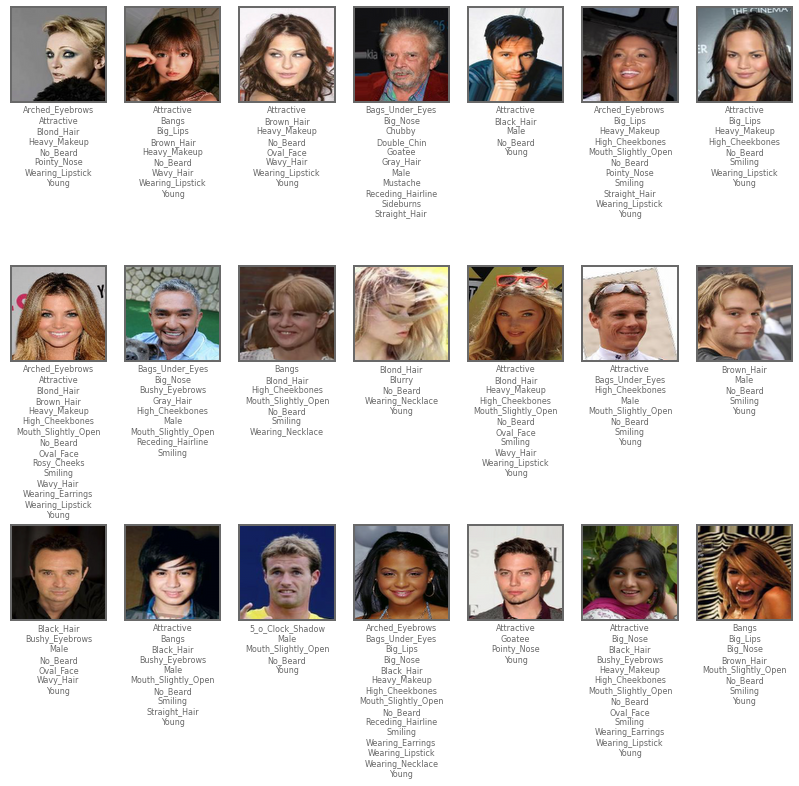

In [4]:
# ---- Return a legend from a description 
#
def get_legend(x_desc,i):
    cols  = x_desc.columns
    desc  = x_desc.iloc[i]
    legend =[]
    for i,v in enumerate(desc):
        if v==1 : legend.append(cols[i])
    return str('\n'.join(legend))

pwk.chrono_start()

# ---- get cluster list
#
clusters_name = [ os.path.splitext(f)[0] for f in glob.glob( f'{train_dir}/*.npy') ]

# ---- Counters set to 0
#
imax  = len(clusters_name)
i,n1,n2,s = 0,0,0,0
imgs,desc = [],[]

# ---- Reload all clusters
#
pwk.subtitle('Reload all clusters...')
pwk.update_progress('Load clusters :',i,imax, redraw=True)
for cluster_name in clusters_name:  
    
    # ---- Reload images and normalize

    x_data = np.load(cluster_name+'.npy')
    
    # ---- Reload descriptions
    
    x_desc = pd.read_csv(cluster_name+'.csv', header=0)
    
    # ---- Counters
    
    n1 += len(x_data)
    n2 += len(x_desc.index)
    s  += x_data.nbytes
    i  += 1
    
    # ---- Get somes images/legends
    
    j=random.randint(0,len(x_data)-1)
    imgs.append( x_data[j].copy() )
    desc.append( get_legend(x_desc,j) )
    x_data=None
    
    # ---- To appear professional
    
    pwk.update_progress('Load clusters :',i,imax, redraw=True)

d=pwk.chrono_stop()

pwk.subtitle('Few stats :')
print(f'Loading time      : {d:.2f} s or {pwk.hdelay(d)}')
print(f'Number of cluster : {i}')
print(f'Number of images  : {n1}')
print(f'Number of desc.   : {n2}')
print(f'Total size of img : {pwk.hsize(s)}')

pwk.subtitle('Have a look (1 image/ cluster)...')
pwk.plot_images(imgs,desc,x_size=2,y_size=2,fontsize=8,columns=7,y_padding=2.5, save_as='image_and_desc')

<div class='nota'>
    <b>Note :</b> With this approach, the use of data is much much more effective !
    <ul>
        <li>Data loading speed : <b>x 10</b> (81 s vs 16 min.)</li>
    </ul>
</div>

## Step 3 - How we will read our data during the train session
We are going to use a "dataset generator", which is an implementation of [tensorflow.keras.utils.Sequence](https://www.tensorflow.org/api_docs/python/tf/keras/utils/Sequence)  
During the trainning, batches will be requested to our DataGenerator, which will read the clusters as they come in.

### 3.1 - An example to understand

In [5]:
# ---- Our DataGenerator

data_gen = DataGenerator(train_dir, batch_size=32, debug=True, k_size=0.2)

# ---- We ask him to retrieve all batchs

batch_sizes=[]
for i in range( len(data_gen)):
    x,y = data_gen[i]
    batch_sizes.append(len(x))

print(f'\n\ntotal number of items : {sum(batch_sizes)}')
print(f'batch sizes      : {batch_sizes}')
print(f'Last batch shape : {x.shape}')



FIDLE 2020 - DataGenerator
Version              : 0.4.1

Clusters nb  : 21 files
Dataset size : 4051
Batch size   : 32

[shuffle!]

[Load 00,s=1000] (32) (32) (32) (32) (32) (32) (32) (32) (32) (32) (32) (32) (32) (32) (32) (32) (32) (32) (32) (32) (32) (32) (32) (32) (32) (32) (32) (32) (32) (32) (32) (8..) 
[Load 01,s=259] (..24) (32) (32) (32) (32) (32) (32) (32) (11..) 
[Load 02,s=1000] (..21) (32) (32) (32) (32) (32) (32) (32) (32) (32) (32) (32) (32) (32) (32) (32) (32) (32) (32) (32) (32) (32) (32) (32) (32) (32) (32) (32) (32) (32) (32) (19..) 
[Load 03,s=1000] (..13) (32) (32) (32) (32) (32) (32) (32) (32) (32) (32) (32) (32) (32) (32) (32) (32) (32) (32) (32) (32) (32) (32) (32) (32) (32) (32) (32) (32) (32) (32) (27..) 
[Load 04,s=1000] (..5) (32) (32) (32) (32) (32) (32) (32) (32) (32) (32) (32) (32) (32) (32) (32) (32) (32) (32) (32) (32) (32) (32) (32) (32) 

total number of items : 4032
batch sizes      : [32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 

In [6]:
pwk.end()

End time is : Saturday 2 January 2021, 17:28:47
Duration is : 00:00:08 736ms
This notebook ends here


---
<img width="80px" src="../fidle/img/00-Fidle-logo-01.svg"></img>